In [1]:
# adapted version of https://www.kaggle.com/cbrogan/titanic/xgboost-example-python/code
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import numpy as np
%matplotlib inline

In [2]:
# Load the data
train_df = pd.read_csv('../data/train.csv', header=0)
test_df = pd.read_csv('../data/test.csv', header=0)
train_df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [3]:
train_df['Intact'], train_df['Sex'] = train_df.SexuponOutcome.str.split(' ').str
train_df['Intact'] = train_df['Intact'].replace('Unknown', np.nan)
train_df['Intact'] = train_df['Intact'].replace('Spayed', 'Neutered')

test_df['Intact'], test_df['Sex'] = test_df.SexuponOutcome.str.split(' ').str
test_df['Intact'] = test_df['Intact'].replace('Unknown', np.nan)

def calc_age_in_days(df):
    factor = {'year': 365, 'month': 31, 'week': 7, 'day': 1}
    result = []
    for age in df.AgeuponOutcome:
        if str(age) != 'nan':
            value, unit = age.split(' ')
            days = int(value) * factor[unit.replace('s', '')] # ignore year[s], month[s], ...
            result.append(days)
        else:
            result.append(np.nan)
    df['AgeuponOutcomeInDays'] = result
    return df

def calc_age_in_years(df):
    result = []
    for age in df.AgeuponOutcomeInDays:
        if str(age) != 'nan':
            years = int(age / 365)
            result.append(years)
        else:
            result.append(np.nan)
    df['AgeuponOutcomeInYears'] = result
    return df

train_df = calc_age_in_days(train_df)
train_df = calc_age_in_years(train_df)
test_df = calc_age_in_days(test_df)
test_df = calc_age_in_years(test_df)


train_df[5:10]

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Intact,Sex,AgeuponOutcomeInDays,AgeuponOutcomeInYears
5,A677334,Elsa,2014-04-25 13:04:00,Transfer,Partner,Dog,Intact Female,1 month,Cairn Terrier/Chihuahua Shorthair,Black/Tan,Intact,Female,31.0,0.0
6,A699218,Jimmy,2015-03-28 13:11:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Tabby,Intact,Male,21.0,0.0
7,A701489,NaN,2015-04-30 17:02:00,Transfer,Partner,Cat,Unknown,3 weeks,Domestic Shorthair Mix,Brown Tabby,NaN,NaN,21.0,0.0
8,A671784,Lucy,2014-02-04 17:17:00,Adoption,NaN,Dog,Spayed Female,5 months,American Pit Bull Terrier Mix,Red/White,Neutered,Female,155.0,0.0
9,A677747,NaN,2014-05-03 07:48:00,Adoption,Offsite,Dog,Spayed Female,1 year,Cairn Terrier,White,Neutered,Female,365.0,1.0


Split `SexuponOutcome` into `Intact` and `Sex`

In [4]:
# We'll impute missing values using the median for numeric columns and the most
# common value for string columns.
# This is based on some nice code by 'sveitser' at http://stackoverflow.com/a/25562948
from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)

# feature_columns_to_use = ['AnimalType', 'Sex', 'Intact', 'Breed']
feature_columns_to_use = ['AnimalType', 'SexuponOutcome', 'Breed', 'AgeuponOutcomeInDays']  # <- best features so far

nonnumeric_columns = feature_columns_to_use

# Join the features from train and test together before imputing missing values,
# in case their distribution is slightly different
# Do we really wanna do this? S/b said this is bad practice for some reason
big_X = train_df[feature_columns_to_use].append(test_df[feature_columns_to_use])
big_X_imputed = DataFrameImputer().fit_transform(big_X)
big_X_imputed[5:10]

,AnimalType,SexuponOutcome,Breed,AgeuponOutcomeInDays
5,Dog,Intact Female,Cairn Terrier/Chihuahua Shorthair,31.0
6,Cat,Intact Male,Domestic Shorthair Mix,21.0
7,Cat,Unknown,Domestic Shorthair Mix,21.0
8,Dog,Spayed Female,American Pit Bull Terrier Mix,155.0
9,Dog,Spayed Female,Cairn Terrier,365.0


Fill in missing fields:
* `mean` if column is numeric
* `most common value` if not numeric

In [5]:
# See http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing for more
# details and options
le = LabelEncoder()
for feature in nonnumeric_columns:
    big_X_imputed[feature] = le.fit_transform(big_X_imputed[feature])

# Prepare the inputs for the model
train_X = big_X_imputed[0:train_df.shape[0]].as_matrix()
test_X = big_X_imputed[train_df.shape[0]::].as_matrix()
train_df.OutcomeType = le.fit_transform(train_df.OutcomeType)
train_y = train_df['OutcomeType']

## Do the actual learning

In [6]:
from sklearn.cross_validation import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, test_size=0.01, random_state=10)

`train_test_split` is a shorthand to randomly split a training set into train/test data for cross validation. 

* `test_size`: sets the percentage of data used for the test set.
* `random_state`: is used to get reproducible randomness

In [7]:
xgmat = xgb.DMatrix(X_train, label=y_train)  # cross validation training set
xgmat_valid = xgb.DMatrix(X_valid, label=y_valid)  # cross validation test set
xgmat_test = xgb.DMatrix(test_X)  # the original test set from kaggle

transforms our generated cross validation data to a format readable by `xgboost`

## Parameters
Some information about parameter tweaking: [click](http://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

### objective
Set against which loss function the algorithm should minimize. What we need: Multiclass with probabilities. So we choose `multi:softprob`. This in return needs a parameter `num_class` which indicates the number of differenct classes. In our case thats the number of distinct values for cloumn `OutcomeType`

### Others
* `eval_metric`: set to `mlogloss`, that is the one kaggle uses
* `max_delta_setp`: set to number > 0 to fight imbalanced data sets (http://xgboost.readthedocs.io/en/latest/how_to/param_tuning.html)

In [8]:
# right know these values fall from the sky. No idea what they mean. Needs investigation
param = {
    'objective': 'multi:softprob',
    'num_class': train_df.OutcomeType.nunique(),  # should be 5
    'eta': 0.35,     # feature weight shrinkrage: lower -> reduce complexity
    'gamma': 0.00,   # loss reduction needed to split a leaf and add another layer: higher -> reduces complexity
    'max_depth': 8,  # maximum depth of a tree: higher -> increase complexity
#     'min_child_weight': 12,  # minimum number of instances in a leaf: higher -> less complexity
    'max_delta_step': 1,    # in logregression a higher value might help with imbalanced classes
    'subsample': 0.5,       # randomly select instances from train set to build trees: lower -> less overfitting
    'colsample_bytree': 0.5, # subsample colums: lower -> less overfitting
    'alpha' : 0,  # regularization weight: higher -> less complex
    'scale_pos_weight': 0,  # fight unbalanced classes: sum(negative cases) / sum(positive cases)
    'eval_metric' : 'mlogloss',
    'silent': 1
}

In [9]:
num_round=3000
watchlist = [(xgmat, 'train'), (xgmat_valid, 'eval')]
gbm = xgb.train(param, xgmat, num_round, watchlist, early_stopping_rounds=100)

Will train until eval error hasn't decreased in 100 rounds.
[0]	train-mlogloss:1.395803	eval-mlogloss:1.408419
[1]	train-mlogloss:1.265999	eval-mlogloss:1.288577
[2]	train-mlogloss:1.156651	eval-mlogloss:1.185825
[3]	train-mlogloss:1.076349	eval-mlogloss:1.110040
[4]	train-mlogloss:1.015077	eval-mlogloss:1.048233
[5]	train-mlogloss:0.976534	eval-mlogloss:1.015617
[6]	train-mlogloss:0.950987	eval-mlogloss:0.994531
[7]	train-mlogloss:0.925922	eval-mlogloss:0.970537
[8]	train-mlogloss:0.905932	eval-mlogloss:0.953498
[9]	train-mlogloss:0.891218	eval-mlogloss:0.943187
[10]	train-mlogloss:0.880818	eval-mlogloss:0.937986
[11]	train-mlogloss:0.873697	eval-mlogloss:0.934317
[12]	train-mlogloss:0.867105	eval-mlogloss:0.931253
[13]	train-mlogloss:0.863476	eval-mlogloss:0.928117
[14]	train-mlogloss:0.855715	eval-mlogloss:0.921430
[15]	train-mlogloss:0.851963	eval-mlogloss:0.918119
[16]	train-mlogloss:0.846929	eval-mlogloss:0.911529
[17]	train-mlogloss:0.842968	eval-mlogloss:0.909998
[18]	train-mlo

We don't just simply learn a model but we observe how the precision evolves [more info](http://xgboost.readthedocs.io/en/latest/python/python_intro.html#training)
* `early_stopping_rounds`: will stop training if the precision did not improve in the set number of rounds
* `watchlist`: contains the parameters to watch while learning

__*train() only returns the last model, not necessarily the best one!*__  see [here](http://xgboost.readthedocs.io/en/latest/python/python_intro.html#prediction)

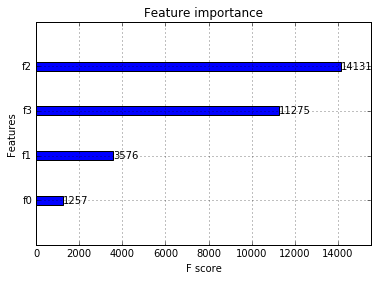

In [10]:
xgb.plot_importance(gbm)

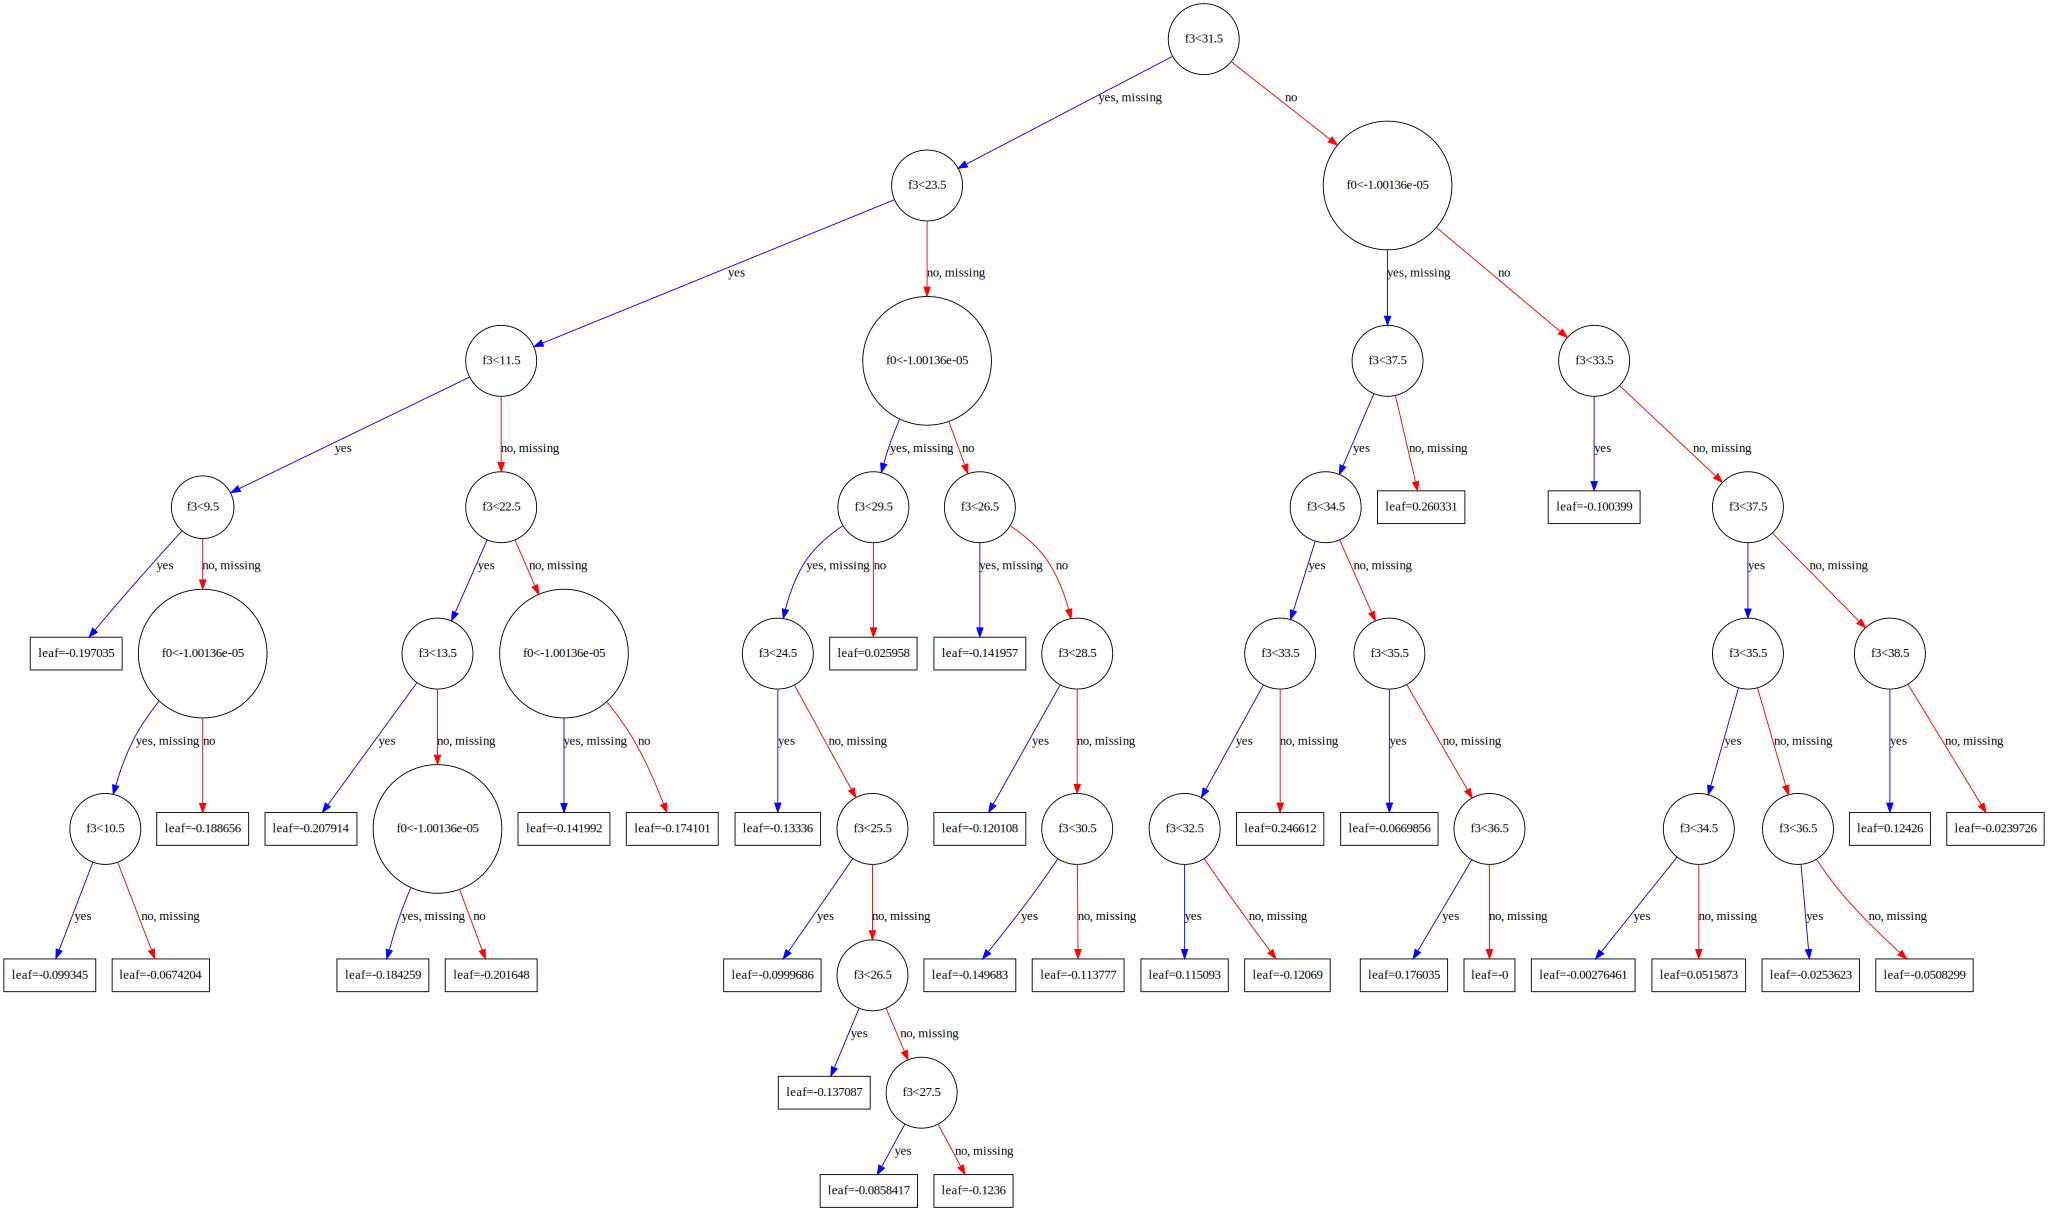

In [11]:
xgb.to_graphviz(gbm, num_trees=2)  # needs graphviz: 'sudo apt-get install graphviz' and 'pip3 install graphviz'

## Predict and save as Kaggel

In [12]:
predictions = gbm.predict(xgmat_test, ntree_limit=gbm.best_ntree_limit)

predictions

/usr/local/lib/python3.5/dist-packages/xgboost/core.py:840: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  preds = preds.reshape(nrow, preds.size / nrow)


array([[ 0.03340414,  0.004338  ,  0.02817257,  0.10423612,  0.82984912],
       [ 0.56669933,  0.00427704,  0.03685544,  0.26300088,  0.12916732],
       [ 0.40608609,  0.00415009,  0.03377846,  0.08589508,  0.4700903 ],
       ..., 
       [ 0.02890982,  0.00744474,  0.08120513,  0.01901138,  0.86342889],
       [ 0.32694387,  0.00275432,  0.04217351,  0.47965699,  0.14847128],
       [ 0.01670447,  0.00267957,  0.10868958,  0.44638035,  0.42554605]], dtype=float32)

In [13]:
# to kaggle format
submission_df = pd.DataFrame(predictions)
submission_df = pd.concat([test_df.ID, submission_df], axis=1)
submission_df.ID = submission_df.ID.astype(int)
submission_df.set_index('ID', inplace=True)
submission_df.columns = le.inverse_transform(sorted(train_df.OutcomeType.unique()))  # get the string labels back
submission_df.head()

,Adoption,Died,Euthanasia,Return_to_owner,Transfer
ID,,,,,
1,0.033404,0.004338,0.028173,0.104236,0.829849
2,0.566699,0.004277,0.036855,0.263001,0.129167
3,0.406086,0.004150,0.033778,0.085895,0.470090
4,0.049436,0.005010,0.072668,0.031631,0.841255
5,0.503743,0.003362,0.021713,0.283018,0.188163


In [14]:
submission_df.to_csv('submission.csv')
len(submission_df)

11456